In [1]:
from Simulation.mpc import *
from Simulation.systemFunctions import DistillationColumnAspen
from utils.helpers import *

## Initialize the system

In [2]:
# System and Snapshot paths
path = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\C2S_SS_simulation3.dynf"
path_snaps = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation3"

In [3]:
# First initiate the system
# Nominal Conditions
nominal_conditions =  np.array([1.50032484e+05, -2.10309105e+01, 2.08083248e+01, 6.30485237e-01, 3.69514734e-01, -2.40000000e+01])

# Steady State inputs
ss_inputs = np.array([320000.0, 110.0])

# Sampling time of the system
delta_t = 1 / 6 # 10 mins

In [4]:
# steady state values
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
steady_states={"ss_inputs":dl.ss_inputs,
               "y_ss":dl.y_ss}
print(steady_states)
dl.close(path_snaps)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
{'ss_inputs': array([3.2e+05, 1.1e+02]), 'y_ss': array([  0.1003974 , -22.95514339])}
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation3\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation3\snpA0001.snp


## Loading the system matrices, min max scaling, and min max of the states

In [5]:
dir_path = os.path.join(os.getcwd(), "Data")

In [6]:
# Defining the range of setpoints for data generation
setpoint_y = np.array([[0.002, -26.0],
                       [0.05, -16.0]])
u_min = np.array([300000.0, 100.0])
u_max = np.array([460000, 150.0])

system_data = load_and_prepare_system_data(steady_states=steady_states, setpoint_y=setpoint_y, u_min=u_min, u_max=u_max)

In [7]:
A_aug = system_data["A_aug"]
B_aug = system_data["B_aug"]
C_aug = system_data["C_aug"]

In [8]:
data_min = system_data["data_min"]
data_max = system_data["data_max"]

In [9]:
min_max_states = system_data["min_max_states"]

In [10]:
y_sp_scaled_deviation = system_data["y_sp_scaled_deviation"]

In [11]:
b_min = system_data["b_min"]
b_max = system_data["b_max"]

In [12]:
min_max_dict = system_data["min_max_dict"]

In [13]:
# Setpoints in deviation form
inputs_number = int(B_aug.shape[1])
y_sp_scenario = np.array([[0.013, -23.],
                         [0.028, -21.]])

y_sp_scenario = (apply_min_max(y_sp_scenario, data_min[inputs_number:], data_max[inputs_number:])
                 - apply_min_max(steady_states["y_ss"], data_min[inputs_number:], data_max[inputs_number:]))

n_tests = 200
set_points_len = 200
TEST_CYCLE = [False, False, False, False, False]
warm_start = 10
ACTOR_FREEZE = 10 * set_points_len
warm_start_plot = warm_start * 2 * set_points_len + ACTOR_FREEZE

In [14]:
# # # Observer Gain
poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
                  0.01153274, 0.41036367])
L = compute_observer_gain(A_aug, C_aug, poles)
# L
# # Observer Gain
# poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
#                   0.5153274, 0.61036367])
# # poles = np.array([0.6, 0.6, 0.55, 0.5, 0.5, 0.98, 0.95])
# L = compute_observer_gain(A_aug, C_aug, poles)
L

The system is observable.


C:\Users\HAMEDI\Desktop\DistillRL\Simulation\mpc.py:120: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a tolerance of 0.001, we got 0.999717148453736.
  obs_gain_calc = signal.place_poles(A.T, C.T, desired_poles, method='KNV0')


array([[-1.28799695e-02, -5.59506263e-05],
       [ 1.52539747e-03,  6.80431626e-01],
       [-2.63810177e+00, -2.87660658e-03],
       [ 1.75971734e-04,  5.00909575e-04],
       [-1.48263330e-03, -6.61765393e-01],
       [ 5.07607473e+00,  4.18895828e-03],
       [ 1.72932984e-03,  2.14676215e+00]])

## Setting The hyperparameters for the TD3 Agent

In [15]:
from SACAgent.sac_agent import SACAgent
import torch

In [16]:
set_points_number = int(C_aug.shape[0])
STATE_DIM = int(A_aug.shape[0]) + set_points_number + inputs_number
ACTION_DIM = int(B_aug.shape[1])
n_outputs = C_aug.shape[0]

ACTOR_LAYER_SIZES = [512, 512, 512, 512, 512]
CRITIC_LAYER_SIZES = [512, 512, 512, 512, 512]
BUFFER_CAPACITY = 200000

ACTOR_LR = 5e-5
CRITIC_LR = 5e-4
ALPHA_LR = 1e-4

GAMMA = 0.995
TAU = 0.005
MAX_ACTION = 1.0

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256

In [17]:
sac_agent = SACAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    actor_hidden=ACTOR_LAYER_SIZES,
    critic_hidden=CRITIC_LAYER_SIZES,
    gamma=GAMMA,
    actor_lr=ACTOR_LR,
    critic_lr=CRITIC_LR,
    alpha_lr=ALPHA_LR,
    batch_size=BATCH_SIZE,
    grad_clip_norm=10.0,
    init_alpha=0.2,
    learn_alpha=True,
    target_entropy=None,
    target_update="soft",
    tau=TAU,
    hard_update_interval=10_000,
    activation="relu",
    use_layernorm=False,
    dropout=0.0,
    max_action=MAX_ACTION,
    buffer_size=BUFFER_CAPACITY,
    use_per=True,
    device=DEVICE,
    use_adamw=True,
    actor_freeze=ACTOR_FREEZE
)

In [18]:
agent_path = r"C:\Users\HAMEDI\Desktop\DistillRL\Data/models\sac_20251205_000521.pkl"
sac_agent.load(agent_path)

Agent loaded successfully from: C:\Users\HAMEDI\Desktop\DistillRL\Data/models\sac_20251205_000521.pkl


## MPC initialization

In [19]:
# MPC parameters
predict_h = 6
cont_h = 3
b1 = (b_min[0], b_max[0])
b2 = (b_min[1], b_max[1])
bnds = (b1, b2)*cont_h
cons = []
IC_opt = np.zeros(inputs_number*cont_h)
Q1_penalty = 1.
Q2_penalty = 1.
R1_penalty = 1.
R2_penalty = 1.

In [20]:
MPC_obj = MpcSolver(A_aug, B_aug, C_aug,
                    Q1_penalty, Q2_penalty, R1_penalty, R2_penalty,
                    predict_h, cont_h)

## Applying RL Agent on the Distillation column

In [21]:
import numpy as np

def make_reward_fn_relative_QR(
    data_min, data_max, n_inputs,
    k_rel, band_floor_phys,
    Q_diag, R_diag,
    tau_frac=0.7,
    gamma_out=0.5, gamma_in=0.5,
    beta=5.0, gate="geom", lam_in=1.0,
    bonus_kind="exp", bonus_k=12.0, bonus_p=0.6, bonus_c=20.0,
):
    """
    Reward with relative tracking bands.

    data_min, data_max : arrays for [u_min..., y_min...], [u_max..., y_max...]
    n_inputs           : number of inputs (so outputs start at index n_inputs)
    k_rel              : per-output relative tolerance factors (same length as outputs)
    band_floor_phys    : per-output minimum band in physical units
    Q_diag, R_diag     : quadratic weights (same as before)
    """

    data_min = np.asarray(data_min, float)
    data_max = np.asarray(data_max, float)
    dy = np.maximum(data_max[n_inputs:] - data_min[n_inputs:], 1e-12)  # phys range for each y

    k_rel = np.asarray(k_rel, float)
    band_floor_phys = np.asarray(band_floor_phys, float)
    Q_diag = np.asarray(Q_diag, float)
    R_diag = np.asarray(R_diag, float)

    # floor in *scaled* coordinates (used if y_sp_phys is not provided)
    band_floor_scaled = band_floor_phys / np.maximum(dy, 1e-12)

    def _sigmoid(x):
        x = np.clip(x, -60.0, 60.0)
        return 1.0 / (1.0 + np.exp(-x))

    def _phi(z, kind=bonus_kind, k=bonus_k, p=bonus_p, c=bonus_c):
        z = np.clip(z, 0.0, 1.0)
        if kind == "linear":
            return 1.0 - z
        if kind == "quadratic":
            return (1.0 - z) ** 2
        if kind == "exp":
            return (np.exp(-k * z) - np.exp(-k)) / (1.0 - np.exp(-k))
        if kind == "power":
            return 1.0 - np.power(z, p)
        if kind == "log":
            return np.log1p(c * (1.0 - z)) / np.log1p(c)
        raise ValueError("unknown bonus kind")

    def reward_fn(e_scaled, du_scaled, y_sp_phys=None):
        """
        e_scaled : output error in scaled deviation space  (same as before)
        du_scaled: input move in scaled deviation space    (same as before)
        y_sp_phys: current setpoint in *physical* units (array len = n_outputs)
        """

        e_scaled = np.asarray(e_scaled, float)
        du_scaled = np.asarray(du_scaled, float)

        # ----- dynamic band based on setpoint -----
        if y_sp_phys is None:
            # fallback: just use the floor
            band_scaled = band_floor_scaled
        else:
            y_sp_phys_arr = np.asarray(y_sp_phys, float)
            # band_phys_i = max(k_rel_i * |y_sp_i|, band_floor_phys_i)
            band_phys = np.maximum(k_rel * np.abs(y_sp_phys_arr), band_floor_phys)
            band_scaled = band_phys / np.maximum(dy, 1e-12)

        tau_scaled = tau_frac * band_scaled

        # ----- inside/outside gate -----
        abs_e = np.abs(e_scaled)
        s_i = _sigmoid((band_scaled - abs_e) / np.maximum(tau_scaled, 1e-12))

        if gate == "prod":
            w_in = float(np.prod(s_i, dtype=np.float64))
        elif gate == "mean":
            w_in = float(np.mean(s_i))
        elif gate == "geom":
            w_in = float(np.prod(s_i, dtype=np.float64) ** (1.0 / len(s_i)))
        else:
            raise ValueError("gate must be 'prod'|'mean'|'geom'")

        # ----- core quadratic costs -----
        err_quad = np.sum(Q_diag * (e_scaled ** 2))
        err_eff = (1.0 - w_in) * err_quad + w_in * (lam_in * err_quad)
        move = np.sum(R_diag * (du_scaled ** 2))

        # ----- linear penalties around band edge -----
        slope_at_edge = 2.0 * Q_diag * band_scaled

        overflow = np.maximum(abs_e - band_scaled, 0.0)
        lin_out = (1.0 - w_in) * np.sum(gamma_out * slope_at_edge * overflow)

        inside_mag = np.minimum(abs_e, band_scaled)
        lin_in = w_in * np.sum(gamma_in * slope_at_edge * inside_mag)

        # ----- bonus near zero error -----
        qb2 = Q_diag * (band_scaled ** 2)
        z = abs_e / np.maximum(band_scaled, 1e-12)
        phi = _phi(z)
        bonus = w_in * beta * np.sum(qb2 * phi)

        # ----- total reward -----
        return -(err_eff + move + lin_out + lin_in) + bonus

    params = dict(
        k_rel=k_rel,
        band_floor_phys=band_floor_phys,
        band_floor_scaled=band_floor_scaled,
        Q_diag=Q_diag,
        R_diag=R_diag,
        tau_frac=tau_frac,
        gamma_out=gamma_out,
        gamma_in=gamma_in,
        beta=beta,
        gate=gate,
        lam_in=lam_in,
        bonus_kind=bonus_kind,
        bonus_k=bonus_k,
        bonus_p=bonus_p,
        bonus_c=bonus_c,
    )
    return params, reward_fn

## Reward configuration

In [22]:
# relative band design
k_rel           = np.array([0.3, 0.02])     # 30% of comp setpoint; 2% of temp magnitude
band_floor_phys = np.array([0.003, 0.3])    # minimum 0.003 comp, 0.3 C

# using nominal y_sp_phys = [0.013, -23.0] to design Q
# (once chosen, Q_diag is fixed)
Q_diag = np.array([3.7e4, 1.5e3])          # rounded from the band-based calculation
R_diag = np.array([2.5e3, 2.5e3])          # move cost for du_scaled ~ 0.02

tau_frac  = 0.7
gamma_out = 0.5
gamma_in  = 0.5
beta      = 7.0                            # gives reward at zero ~20-ish
gate      = "geom"
lam_in    = 1.0
bonus_kind= "exp"
bonus_k   = 12.0
bonus_p   = 0.6
bonus_c   = 20.0

n_inputs = 2

print("Band scaled are:")

params, reward_fn = make_reward_fn_relative_QR(
    data_min, data_max, n_inputs,
    k_rel, band_floor_phys,
    Q_diag, R_diag,
    tau_frac=tau_frac,
    gamma_out=0.5, gamma_in=0.5,
    beta=7.0, gate="geom", lam_in=1.0,
    bonus_kind="exp", bonus_k=12.0, bonus_p=0.6, bonus_c=20.0,
)
print(params)

Band scaled are:
{'k_rel': array([0.3 , 0.02]), 'band_floor_phys': array([0.003, 0.3  ]), 'band_floor_scaled': array([0.00562241, 0.01684214]), 'Q_diag': array([37000.,  1500.]), 'R_diag': array([2500., 2500.]), 'tau_frac': 0.7, 'gamma_out': 0.5, 'gamma_in': 0.5, 'beta': 7.0, 'gate': 'geom', 'lam_in': 1.0, 'bonus_kind': 'exp', 'bonus_k': 12.0, 'bonus_p': 0.6, 'bonus_c': 20.0}


## Reward annealing technique

In [23]:
# y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes, test_train_dict, WARM_START = generate_setpoints_training_rl(
#         y_sp_scenario, n_tests, set_points_len, warm_start, TEST_CYCLE)
# TODO SETpoint mistmatch

You are using y_sp[i, :] in next_rl_state rather than y_sp[i+1, :]. Again, inside the block they are equal, but immediately after setpoint change this means the next state contains the “old” setpoint. That is a tiny mismatch with the actual Markov process you care about. Not catastrophic, but if you clean it up, the chain is more interpretable.

In [24]:
def run_rl_train(system, y_sp_scenario, n_tests, set_points_len,
                 steady_states, min_max_dict, agent, MPC_obj,
                 L, data_min, data_max, warm_start,
                 test_cycle,
                 reward_fn):

    # defining setpoints
    y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes, test_train_dict, WARM_START = generate_setpoints_training_rl(
        y_sp_scenario, n_tests, set_points_len, warm_start, test_cycle)
    
    # inputs and outputs of the system dimensions
    n_inputs = B_aug.shape[1]
    n_outputs = C_aug.shape[0]
    n_states = A_aug.shape[0]
    
    # Scaled steady states inputs and outputs
    ss_scaled_inputs = apply_min_max(steady_states["ss_inputs"], data_min[:n_inputs], data_max[:n_inputs])
    y_ss_scaled = apply_min_max(steady_states["y_ss"], data_min[n_inputs:], data_max[n_inputs:])
    u_min, u_max = min_max_dict["u_min"], min_max_dict["u_max"]

    y_system = np.zeros((nFE + 1, n_outputs))
    y_system[0, :] = system.current_output
    u_rl = np.zeros((nFE, n_inputs))
    yhat = np.zeros((n_outputs, nFE))
    xhatdhat = np.zeros((n_states, nFE + 1))
    # xhatdhat[:, 0] = np.random.uniform(low=min_max_dict["x_min"], high=min_max_dict["x_max"])
    rewards = np.zeros(nFE)
    avg_rewards = []

    delta_y_storage = []

    # boundary definition
    boundary = time_in_sub_episodes / 2 # two setpoints
    
    # ----- helper ------
    def map_to_bounds(a, low, high):
        return low + ((a + 1.0) / 2.0) * (high - low)

    test = False

    for i in range(nFE):
        # train/test phase
        if i in test_train_dict:
            test = test_train_dict[i]

        # Current scaled input & deviation
        scaled_current_input = apply_min_max(system.current_input, data_min[:n_inputs], data_max[:n_inputs])
        scaled_current_input_dev = scaled_current_input - ss_scaled_inputs

        # ---- RL state (scaled) ----
        current_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i], y_sp[i, :], scaled_current_input_dev)

        # ---- TD3 action ----
        if not test:
            action = agent.take_action(current_rl_state, explore=(not test))
        else:
            action = agent.act_eval(current_rl_state)
        # Map to bounds
        u_scaled = map_to_bounds(action, u_min, u_max)

        # scale & step plant
        u_rl[i, :] = u_scaled + ss_scaled_inputs
        u_plant = reverse_min_max(u_rl[i, :], data_min[:n_inputs], data_max[:n_inputs])

        # delta u cost variables
        delta_u = u_rl[i, :] - scaled_current_input

        # Apply to plant and step
        system.current_input = u_plant
        system.step()

        # Record output
        y_system[i+1, :] = system.current_output

        # ----- Observer & model roll -----
        y_current_scaled = apply_min_max(y_system[i+1, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled
        y_prev_scaled = apply_min_max(y_system[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Calculate Delta y in deviation form
        delta_y = y_current_scaled - y_sp[i, :]

        # Calculate the next state in deviation form
        yhat[:, i] = np.dot(MPC_obj.C, xhatdhat[:, i])
        xhatdhat[:, i+1] = np.dot(MPC_obj.A, xhatdhat[:, i]) + np.dot(MPC_obj.B, (u_rl[i, :] - ss_scaled_inputs)) + np.dot(L, (y_prev_scaled - yhat[:, i])).T

        # y_sp in physical band
        y_sp_phys = reverse_min_max(y_sp[i, :] + y_ss_scaled, data_min[n_inputs:], data_max[n_inputs:])
        
        # Reward Calculation
        reward = reward_fn(delta_y, delta_u, y_sp_phys)
        
        # Record rewards and delta_y
        rewards[i] = reward
        delta_y_storage.append(np.abs(delta_y))

        # ----- Next state for TD3 -----
        next_u_dev = u_rl[i, :] - ss_scaled_inputs
        next_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i+1], y_sp[i, :], next_u_dev)
        
        # Episode boundary (treat each setpoint block as an episode end)
        # done = 1.0 if (i + 1) % boundary == 0 else 0.0
        done = 0.0

        # Buffer + train (skip if in test phase)
        if not test:
            agent.push(current_rl_state,
                       action.astype(np.float32),
                       float(reward),
                       next_rl_state,
                       float(done))
            if i >= WARM_START:
                _ = agent.train_step()  # returns loss or None

        # diagnostics at sub-episode boundary
        if i in sub_episodes_changes_dict:
            avg_rewards.append(np.mean(rewards[max(0, i - time_in_sub_episodes + 1): i + 1]))
            print('Sub_Episode:', sub_episodes_changes_dict[i], '| avg. reward:', avg_rewards[-1])
            if hasattr(agent, "_expl_sigma"):
                print('Exploration noise:', agent._expl_sigma)

    # unscale to plant units for plotting
    u_rl = reverse_min_max(u_rl, data_min[:n_inputs], data_max[:n_inputs])
    
    return y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage

In [25]:
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage\
    = run_rl_train(dl, y_sp_scenario, n_tests, set_points_len,
                 steady_states, min_max_dict, sac_agent, MPC_obj,
                 L, data_min, data_max, warm_start,
                 TEST_CYCLE,
                 reward_fn)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
Sub_Episode: 1 | avg. reward: -9604.849836337204


KeyboardInterrupt: 

In [41]:
dl.close(path_snaps)
# TODO different penalties

Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation2\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation2\snpA0001.snp


In [42]:
def plot_rl_results_disturbance(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_mpc, u_mpc, avg_rewards, data_min, data_max, warm_start_plot,
    directory=None, prefix_name="agent_result",
    agent=None,                 # expects .actor_losses, .critic_losses (lists/arrays)
    delta_y_storage=None,       # list/array of shape (N, 2)
    rewards=None,               # per-step rewards, 1D
    dist=None   # kept for completeness, but not plotted
):
    """
    Plot RL results with warm-start shading; save all inputs + figures
    into directory/prefix_name/<timestamp>. Also plots optional losses,
    delta_y windows, and per-step rewards when provided.
    NOTE: figures are saved only; not shown.
    Returns
    -------
    out_dir : str
        The folder where inputs and figures were saved.
    """
    import os, pickle
    from datetime import datetime
    import numpy as np
    import matplotlib.pyplot as plt

    # ---------- output directory ----------
    if directory is None:
        directory = os.getcwd()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = os.path.join(directory, prefix_name, timestamp)
    os.makedirs(out_dir, exist_ok=True)

    # ---------- helper: save current figure (no show) ----------
    def _savefig(name):
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, name), bbox_inches='tight', dpi=300)
        plt.close()

    # ---------- preserve originals & pack inputs ----------
    y_sp_original = np.array(y_sp, copy=True)  # before conversion

    actor_losses = getattr(agent, "actor_losses", None) if agent is not None else None
    critic_losses = getattr(agent, "critic_losses", None) if agent is not None else None
    dy_arr = np.array(delta_y_storage) if delta_y_storage is not None else None
    rewards_arr = np.array(rewards) if rewards is not None else None

    input_data = {
        "y_sp": y_sp_original,             # original (scaled deviation)
        "steady_states": steady_states,
        "nFE": nFE,
        "delta_t": delta_t,
        "time_in_sub_episodes": time_in_sub_episodes,
        "y_mpc": y_mpc,
        "u_mpc": u_mpc,
        "avg_rewards": avg_rewards,
        "data_min": data_min,
        "data_max": data_max,
        "warm_start_plot": warm_start_plot,
        "actor_losses": actor_losses,
        "critic_losses": critic_losses,
        "delta_y_storage": dy_arr,
        "rewards": rewards_arr,
        "dist": dist,
    }
    with open(os.path.join(out_dir, 'input_data.pkl'), 'wb') as f:
        pickle.dump(input_data, f)

    # ---------- your original plotting code (unchanged logic; save-only) ----------
    # Canceling the deviation form (unchanged logic)
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # -------- visual style only --------
    import matplotlib as mpl
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,    # solid white legend box
    })
    # Distinct, colorblind-safe colors
    C_RL = "tab:blue"
    C_SP = "tab:red"
    C_QC = "tab:green"
    C_QM = "tab:orange"
    C_RW = "tab:purple"

    ####### Plot 1  ###############
    time_plot = np.linspace(0, nFE * delta_t, nFE + 1)
    warm_start_plot = np.atleast_1d(warm_start_plot) * delta_t
    ws_end = float(warm_start_plot.max())

    time_plot_hour = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes + 1)

    from matplotlib.patches import Patch
    import matplotlib.ticker as mtick

    plt.figure(figsize=(10, 8))

    # First subplot
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot[10:], y_mpc[10:, 0], 'b-', lw=2, label=r'$\mathbf{RL}$', zorder=2)
    ax.step(time_plot[10:-1], y_sp[0, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$', where='post', zorder=3)
    for t_ws in warm_start_plot:
        ax.axvline(t_ws, color='k', linestyle='--', linewidth=1.2, zorder=1)
    ax.axvspan(0.0, ws_end, facecolor='0.9', alpha=0.6, zorder=0)
    ax.set_ylabel(r'$\mathbf{\eta}$ (L/g)', fontsize=18)
    ax.grid(True)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.tick_params(axis='x', pad=4)
    h, l = ax.get_legend_handles_labels()
    ax.legend([Patch(facecolor='0.9', edgecolor='none', label='Warm start')] + h,
              ['Warm start'] + l,
              loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0.,
              frameon=True, fontsize=16)

    # Second subplot
    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot[10:], y_mpc[10:, 1], 'b-', lw=2, label=r'$\mathbf{RL}$', zorder=2)
    ax.step(time_plot[10:-1], y_sp[1, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$', where='post', zorder=3)
    for t_ws in warm_start_plot:
        ax.axvline(t_ws, color='k', linestyle='--', linewidth=1.2, zorder=1)
    ax.axvspan(0.0, ws_end, facecolor='0.9', alpha=0.6, zorder=0)
    ax.set_ylabel(r'$\mathbf{T}$ (K)', fontsize=18)
    ax.set_xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    ax.grid(True)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.tick_params(axis='x', pad=4)
    h, l = ax.get_legend_handles_labels()
    ax.legend([Patch(facecolor='0.9', edgecolor='none', label='Warm start')] + h,
              ['Warm start'] + l,
              loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0.,
              frameon=True, fontsize=16)

    plt.subplot(2, 1, 1); plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2); plt.tick_params(axis='both', labelsize=16)
    plt.gcf().subplots_adjust(right=0.82, bottom=0.12)
    _savefig('fig_rl_outputs_full.png')

    ########### last window (= time_in_sub_episodes) ##########
    plt.figure(figsize=(7.6, 5.2))
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 0], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[0, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$\eta$ (L/g)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 1], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[1, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T$ (K)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig(f'fig_rl_outputs_last{time_in_sub_episodes}.png')

    ########### last 4×window ##########
    plt.figure(figsize=(7.6, 5.2))
    time_plot_4w = np.linspace(0, 4 * time_in_sub_episodes * delta_t, 4 * time_in_sub_episodes + 1)

    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot_4w, y_mpc[nFE - 4 * time_in_sub_episodes:, 0], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_4w[:-1], y_sp[0, nFE - 4 * time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$\eta$ (L/g)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot_4w, y_mpc[nFE - 4 * time_in_sub_episodes:, 1], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_4w[:-1], y_sp[1, nFE - 4 * time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T$ (K)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig(f'fig_rl_outputs_last{4*time_in_sub_episodes}.png')

    ####### Plot 2  (inputs) ###############
    plt.figure(figsize=(7.6, 5.2))
    ax = plt.subplot(2, 1, 1)
    ax.step(time_plot[:-1], u_mpc[:, 0], where='post', lw=2.2, color=C_QC, label=r'$Q_c$', zorder=2)
    ax.set_ylabel(r'$Q_c$ (L/h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.step(time_plot[:-1], u_mpc[:, 1], where='post', lw=2.2, color=C_QM, label=r'$Q_m$', zorder=2)
    ax.set_ylabel(r'$Q_m$ (L/h)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig('fig_rl_inputs_full.png')

    ############# Plot 3 (Reward per episode) #######################
    plt.figure(figsize=(7.2, 4.2))
    xep = np.arange(1, len(avg_rewards) + 1)
    plt.plot(xep, avg_rewards, 'o-', lw=2.2, color=C_RW, label='Reward per Episode', zorder=2)
    plt.ylabel('Avg. Reward')
    plt.xlabel('Episode #')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.35)
    ax = plt.gca()
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right', framealpha=1.0, facecolor='white')
    _savefig('fig_rl_rewards.png')

    # ---------- optional losses ----------
    if actor_losses is not None and len(actor_losses) > 0:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(actor_losses, lw=1.8, color='tab:blue')
        plt.ylabel('Actor Loss'); plt.xlabel('Update Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('loss_actor.png')

    if critic_losses is not None and len(critic_losses) > 0:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(critic_losses, lw=1.8, color='tab:orange')
        plt.ylabel('Critic Loss'); plt.xlabel('Update Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('loss_critic.png')

    # ---------- optional delta_y windows ----------
    if dy_arr is not None and dy_arr.ndim == 2 and dy_arr.shape[1] >= 2:
        n = dy_arr.shape[0]

        # last 300
        i0 = max(0, n-300); w = dy_arr[i0:n]
        if len(w) > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.plot(w[:, 0], c='r', label=r'$\Delta y_1$')
            plt.plot(w[:, 1], c='b', label=r'$\Delta y_2$')
            plt.ylabel(r'$\Delta y$'); plt.xlabel('Step'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('delta_y_last300.png')

        # slice [-700:-400]
        j0 = max(0, n-700); j1 = max(0, n-400)
        w2 = dy_arr[j0:j1]
        if len(w2) > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.plot(w2[:, 0], c='r', label=r'$\Delta y_1$')
            plt.plot(w2[:, 1], c='b', label=r'$\Delta y_2$')
            plt.ylabel(r'$\Delta y$'); plt.xlabel('Step'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('delta_y_700_400.png')

    # ---------- optional per-step rewards ----------
    if rewards_arr is not None and rewards_arr.ndim == 1 and rewards_arr.size > 0:
        n = rewards_arr.size
        # [-700:-400]
        j0 = max(0, n-700); j1 = max(0, n-400); w = rewards_arr[j0:j1]
        if w.size > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.scatter(range(w.size), w, s=10)
            plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('rewards_700_400.png')

        # last 300
        i0 = max(0, n-300); w2 = rewards_arr[i0:n]
        if w2.size > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.scatter(range(w2.size), w2, s=10)
            plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('rewards_last300.png')

        # full
        plt.figure(figsize=(7.6, 4.2))
        plt.scatter(range(rewards_arr.size), rewards_arr, s=10)
        plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('rewards_all.png')

    # ---------- disturbance ----------
    if dist is not None:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(time_plot[10:], dist[9:], lw=1.8, color='tab:blue')
        plt.ylabel('Reflux (Kg/h)'); plt.xlabel('Time (hour)'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('feed_dist.png')

    return out_dir

In [43]:
out_dir = plot_rl_results_disturbance(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_system, u_rl, avg_rewards, data_min, data_max, warm_start_plot,
    directory=dir_path, prefix_name="dl_no_disturb",
    agent=td3_agent, delta_y_storage=delta_y_storage, rewards=rewards,
)
print("Saved to:", out_dir)

Saved to: C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_no_disturb\20251116_105012


In [96]:
min_max_states

{'min_s': array([-0.2, -0.2, -0.5, -0.2, -0.5, -1.5, -2. ]),
 'max_s': array([0.5, 0.5, 1.5, 1. , 0.1, 1. , 1. ])}

In [97]:
np.min(xhatdhat, axis=1)

array([-0.0591911 , -0.10559904, -0.47537139, -0.24078269, -0.47033313,
       -1.80191432, -1.78379232])

In [98]:
np.max(xhatdhat, axis=1)

array([0.40773175, 0.51636684, 1.7446081 , 1.00067586, 0.0990744 ,
       0.88736875, 0.76717872])

In [104]:
Q_diag = np.array([90000.0, 30000.0])
R_diag = np.array([100.0, 100.0])

y_band_phys = np.array([10e-4, 0.05])
# y_band_phys = np.array([0.005, 0.1])
print("Band scaled are:")

params, reward_fn = make_reward_fn_fixed_QR(
        data_min, data_max, inputs_number,
        y_band_phys,
        Q_diag, R_diag,
        tau_frac=0.7,
        gamma_out=.7, gamma_in=.7,
        beta=140., gate="geom", lam_in=1.0,
        bonus_kind="exp", bonus_k=12.0, bonus_p=0.6, bonus_c=20.0)
print(params)

Band scaled are:
[0.00187414 0.00280702]
{'Q_diag': array([90000., 30000.]), 'R_diag': array([100., 100.]), 'band_scaled': array([0.00187414, 0.00280702]), 'tau_scaled': array([0.00131189, 0.00196492]), 'gamma_out': 0.7, 'gamma_in': 0.7, 'beta': 140.0, 'gate': 'geom', 'lam_in': 1.0, 'bonus_kind': 'exp', 'bonus_k': 12.0, 'bonus_p': 0.6, 'bonus_c': 20.0, 'bonus_scale_mode': 'qb2'}


In [105]:
save_path = os.path.join(dir_path, "mpc_results_200.pickle")
with open(save_path, 'rb') as file:
    mpc_results = pickle.load(file)
y_mpc = mpc_results["y_mpc"]
u_mpc = mpc_results["u_mpc"]
avg_rewards_ = mpc_results["avg_rewards"]
avg_rewards_mpc = mpc_results["avg_rewards_mpc"]
delta_y_storage_mpc = mpc_results["delta_y_storage"]
delta_u_storage_mpc = mpc_results["delat_u_storage"]

In [106]:
y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes, test_train_dict, WARM_START = generate_setpoints_training_rl(
        y_sp_scenario, n_tests, set_points_len, warm_start, TEST_CYCLE)
avg_reward_mpc_ = []

In [107]:
delta_y_storage_mpc = np.array(delta_y_storage_mpc)
delta_u_storage_mpc = np.array(delta_u_storage_mpc)
rewards_mpc_ = np.zeros(len(delta_u_storage_mpc))
for i in range(len(delta_y_storage_mpc)):
    rewards_mpc_[i] = reward_fn(delta_y_storage_mpc[i], delta_u_storage_mpc[i])
    if i in sub_episodes_changes_dict:
        avg_reward_mpc_.append(np.mean(rewards_mpc_[max(0, i - time_in_sub_episodes + 1): i + 1]))

In [108]:
avg_reward_mpc_

[np.float64(-17.594857359444987), np.float64(11.763922621072078)]

In [109]:
def compare_mpc_rl(y_rl, y_mpc, y_sp, avg_rewards_rl, avg_rewards_mpc,
                   delta_t, directory, prefix_name):
    """
    Plots last-portion comparison (RL vs MPC vs Setpoint) and reward curves.
    Saves to:
      - outputs_compare.(png|pdf)
      - reward_compare.(png|pdf)
    Data logic and inputs remain yours.
    """
    # ---------- output directory ----------
    import os, pickle
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = os.path.join(directory, prefix_name, timestamp)
    os.makedirs(out_dir, exist_ok=True)

    # ---------- helper: save current figure (PNG + PDF; no show) ----------
    import matplotlib.pyplot as plt
    def _savefig(name_png):
        plt.tight_layout()
        full_png = os.path.join(out_dir, name_png)
        plt.savefig(full_png, bbox_inches='tight', dpi=300)
        base, _ = os.path.splitext(full_png)
        plt.savefig(base + '.pdf', bbox_inches='tight')
        plt.close()

    start_idx = -800

    # --- Setpoint back to real units (your convention) ---
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T  # shape (nFE, 2)

    import matplotlib as mpl
    import matplotlib.ticker as mtick
    import numpy as np

    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    # Colors/styles (colorblind-safe)
    C_RL = "tab:blue"
    C_MPC = "black"
    C_SP = "tab:red"

    # --- Tail slices (keep your start_idx; align lengths for line vs step) ---
    y_rl_tail  = np.asarray(y_rl[start_idx:, :],  float)    # (L_line, 2)
    y_mpc_tail = np.asarray(y_mpc[start_idx:, :], float)    # (L_line, 2)
    sp_tail    = np.asarray(y_sp[start_idx:, :],  float)    # (2, W_step)

    # Determine aligned window W where step has W and lines have W+1 samples
    L_line = min(y_rl_tail.shape[0], y_mpc_tail.shape[0])
    W_step = sp_tail.shape[1]
    W = min(W_step, L_line - 1)  # ensure consistent time base

    # Crop to aligned sizes
    y_rl_tail  = y_rl_tail[-(W + 1):, :]
    y_mpc_tail = y_mpc_tail[-(W + 1):, :]
    sp_tail    = sp_tail[:, -W:]               # (2, W)

    # Time bases (hours): line has W+1, step has W (post-hold)
    t_line = np.linspace(0, W * delta_t, W + 1)
    t_step = t_line[:-1]

    # ---------------- Outputs compare (last W) ----------------
    fig, axs = plt.subplots(2, 1, figsize=(7.6, 5.2), sharex=True)

    # Tray 23 C2H6 composition
    ax = axs[0]
    ax.plot(t_line, y_rl_tail[:, 0], '-',  lw=2.2, color=C_RL,  label="RL",  zorder=2)
    ax.plot(t_line, y_mpc_tail[:, 0], '--', lw=2.2, color=C_MPC, label="MPC", zorder=2)
    ax.step(t_step, sp_tail[0, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label="Setpoint", zorder=3)
    ax.set_ylabel(r'$x_{23,\mathrm{C_2H_6}}$ (–)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, t_line[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0),
              borderaxespad=0., framealpha=1.0, facecolor='white')

    # Tray 85 temperature
    ax = axs[1]
    ax.plot(t_line, y_rl_tail[:, 1], '-',  lw=2.2, color=C_RL,  label="RL",  zorder=2)
    ax.plot(t_line, y_mpc_tail[:, 1], '--', lw=2.2, color=C_MPC, label="MPC", zorder=2)
    ax.step(t_step, sp_tail[1, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label="Setpoint", zorder=3)
    ax.set_ylabel(r'$T_{85}$ (K)'); ax.set_xlabel('Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, t_line[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0),
              borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    fig.tight_layout()
    _savefig('outputs_compare.png')

    # ---------------- Rewards: full with outside inset (legend outside) ----------------
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

    fig, ax = plt.subplots(figsize=(7.2, 4.6))

    # main plot
    x_main = np.arange(1, len(avg_rewards_rl))
    ax.plot(x_main, avg_rewards_rl[1:], 'o-', lw=2, ms=4, color='tab:blue',   label='RL')
    ax.hlines(avg_rewards_mpc[-1], xmin=x_main[0], xmax=x_main[-1],
              color='tab:orange', linestyle='--', lw=2, label='MPC')

    ax.set_ylabel('Avg. Reward')
    ax.set_xlabel('Episode #')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(8, integer=True))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))

    # legend OUTSIDE (right)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0),
              borderaxespad=0., frameon=True, facecolor='white')

    # inset: CENTER RIGHT just outside the axes
    axins = zoomed_inset_axes(
        ax, zoom=2.0, loc='center right',
        bbox_to_anchor=(1.02, 0.5),   # outside, vertically centered
        bbox_transform=ax.transAxes,
        borderpad=0.0
    )

    # inset data (same as main)
    axins.plot(x_main, avg_rewards_rl[1:], 'o-', lw=1.8, ms=3.5, color='tab:blue')
    axins.hlines(avg_rewards_mpc[-1], xmin=x_main[0], xmax=x_main[-1],
                 color='tab:orange', linestyle='--', lw=1.8)

    # zoom window (edit these only)
    x1, x2, y1, y2 = 70, 85, 30, 60
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(True, linestyle='--', alpha=0.35)
    axins.spines['top'].set_visible(False); axins.spines['right'].set_visible(False)
    axins.xaxis.set_major_locator(mtick.MaxNLocator(4, integer=True))
    axins.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    axins.tick_params(labelsize=9)

    # box zoom connectors (rectangle + links) — box draws behind lines
    mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.6", lw=1.1)

    # SAVE paper-ready
    _savefig('reward_compare.png')

In [110]:
compare_mpc_rl(y_system, y_mpc, y_sp, avg_rewards, avg_reward_mpc_, delta_t, dir_path, prefix_name="compare_reward_ndist")

C:\Users\HAMEDI\AppData\Local\Temp\ipykernel_65116\1610929490.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [120]:
def compare_mpc_rl_disturbance(y_rl, y_mpc, y_sp, u_mpc, u_rl, avg_rewards_rl, avg_rewards_mpc, time_in_sub_episodes, delta_t):

    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # --- Plot the "last portion" (time_in_sub_episodes) ---
    # Convert those steps to their own time axis
    time_plot_sub = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes)
    start_idx = -400

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as mtick
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    plt.figure(figsize=(10, 8))

    # Subplot 1: last portion, y[:, 0]
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, y_rl[start_idx:, 0], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 0], 'k--', lw=2)
    plt.step(time_plot_sub,
             y_sp[0, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$x_{24,\mathrm{C_2H_6}}$', fontsize=18)
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)

    # Subplot 2: last portion, y[:, 1]
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, y_rl[start_idx:, 1], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 1], 'k--', lw=2)
    plt.step(time_plot_sub,
             y_sp[1, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$T_{85}$ (K)', fontsize=18)
    plt.xlabel(r'Time (hour)', fontsize=18, fontweight='bold')
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)
    #
    # Ticks
    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()
    

    # Subplot 2: Avg rewards
    plt.figure(figsize=(10, 8))
    avg_rewards_rl = avg_rewards_rl[50:]

    plt.plot(np.arange(1, len(avg_rewards_rl) + 1), avg_rewards_rl, 'bo-', lw=2)
    # plt.plot(np.arange(1, len(avg_rewards_mpc) + 1), avg_rewards_mpc, 'ro-', lw=2, label='Reward MPC per Episode')
    plt.hlines(avg_rewards_mpc[-1], xmin=0, xmax=np.arange(1, len(avg_rewards_rl) + 1)[-1], linestyles='--', lw=2)
    plt.ylabel(r'Avg. Reward', fontsize=16, fontweight='bold')
    plt.xlabel(r'Episode #', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    # plt.hlines(-3.0233827500429884)
    # plt.xticks(np.arange(1, len(avg_rewards) + 1), fontsize=14, fontweight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.legend(loc='best', fontsize=16)
    
    # Subplot 3: Manipulated inputs
    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, u_rl[start_idx:, 0], 'b-', lw=2, label=r'RL')
    plt.plot(time_plot_sub, u_mpc[start_idx:, 0], 'k--', lw=2, label=r'MPC')
    plt.ylabel(r'$\mathbf{R}$ (kg/h)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, u_rl[start_idx:, 1], 'b-', lw=2, label=r'RL')
    plt.plot(time_plot_sub, u_mpc[start_idx:, 1], 'k--', lw=2, label=r'MPC')
    plt.ylabel(r'$\mathbf{Q}_R$ (Gj/h)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

    plt.show()

In [128]:
save_path = os.path.join(dir_path, r"C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_no_disturb\20251111_183330\input_data.pkl")
with open(save_path, 'rb') as file:
    rl_results = pickle.load(file)

In [129]:
y_system = rl_results["y_mpc"]
y_sp = rl_results["y_sp"]
u_rl = rl_results["u_mpc"]
avg_rewards = rl_results["avg_rewards"]
time_in_sub_episodes = rl_results["time_in_sub_episodes"]

In [130]:
save_path = os.path.join(dir_path,
                         r"C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_no_disturb\20250918_114552\input_data.pkl")
with open(save_path, 'rb') as file:
    rl_results_1 = pickle.load(file)
y_system1 = rl_results_1["y_mpc"]

In [131]:
y_system1 = np.concatenate((y_system1[-800:-600], y_system1[-400:-200]), axis=0)

In [132]:
def compare_mpc_rl_rl1(y_rl, y_mpc, y_sp, time_in_sub_episodes, delta_t, y_rl2):

    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # --- Plot the "last portion" (time_in_sub_episodes) ---
    # Convert those steps to their own time axis
    time_plot_sub = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes)
    start_idx = -400

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as mtick
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    plt.figure(figsize=(10, 8))

    # Subplot 1: last portion, y[:, 0]
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, y_rl[start_idx:, 0], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 0], 'k--', lw=2)
    plt.plot(time_plot_sub, y_rl2[start_idx:, 0], 'g-', lw=2)
    plt.step(time_plot_sub,
             y_sp[0, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$x_{24,\mathrm{C_2H_6}}$', fontsize=18)
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)

    # Subplot 2: last portion, y[:, 1]
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, y_rl[start_idx:, 1], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 1], 'k--', lw=2)
    plt.plot(time_plot_sub, y_rl2[start_idx:, 1], 'g-', lw=2)
    plt.step(time_plot_sub,
             y_sp[1, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$T_{85}$ (K)', fontsize=18)
    plt.xlabel(r'Time (hour)', fontsize=18, fontweight='bold')
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)
    #
    # Ticks
    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

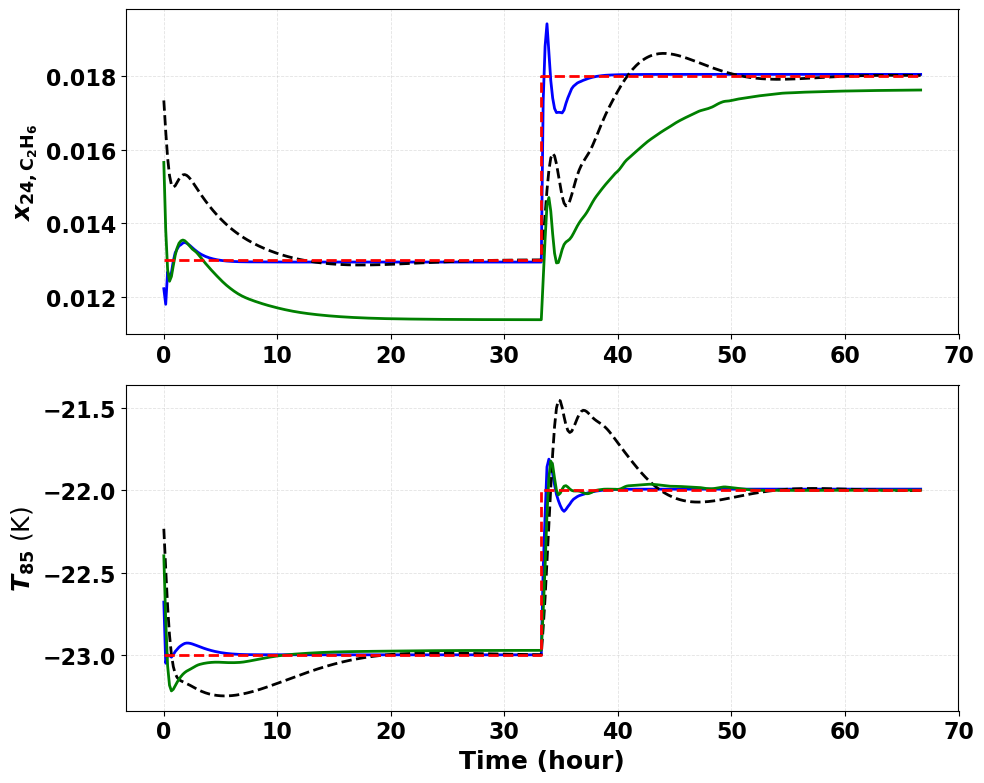

In [133]:
compare_mpc_rl_rl1(y_system, y_mpc, y_sp, time_in_sub_episodes, delta_t, y_system1)

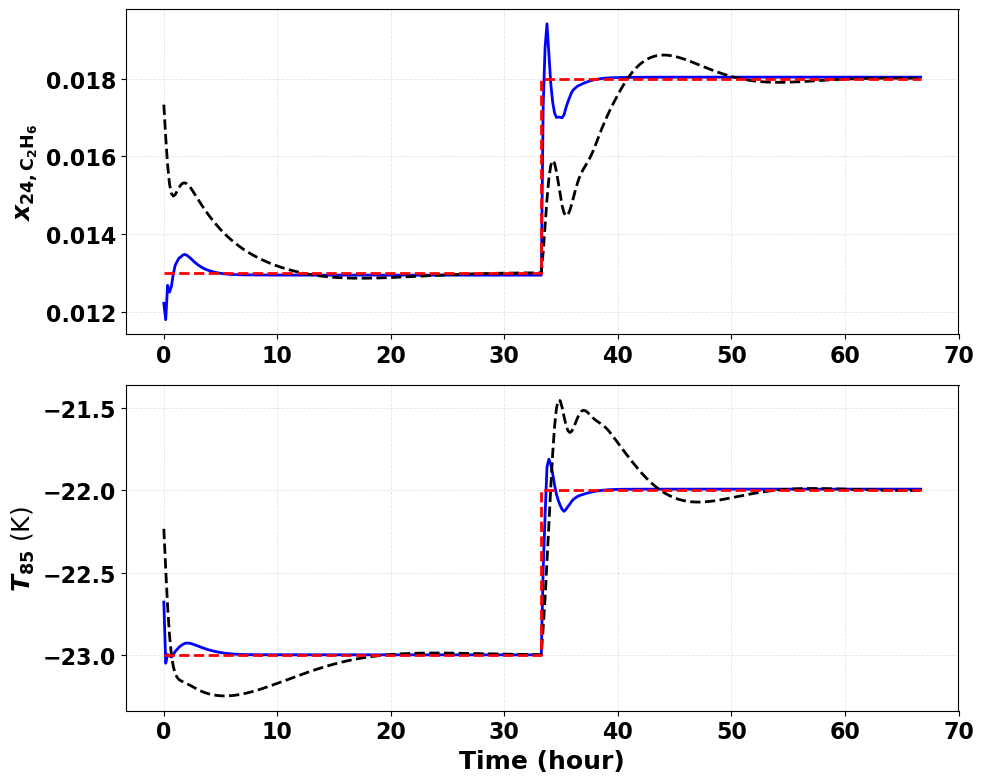

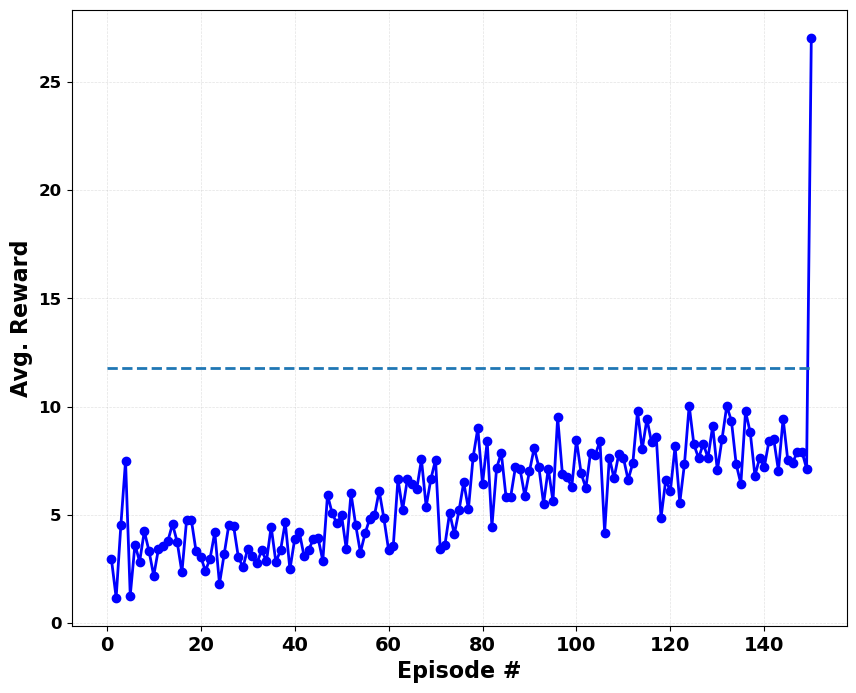

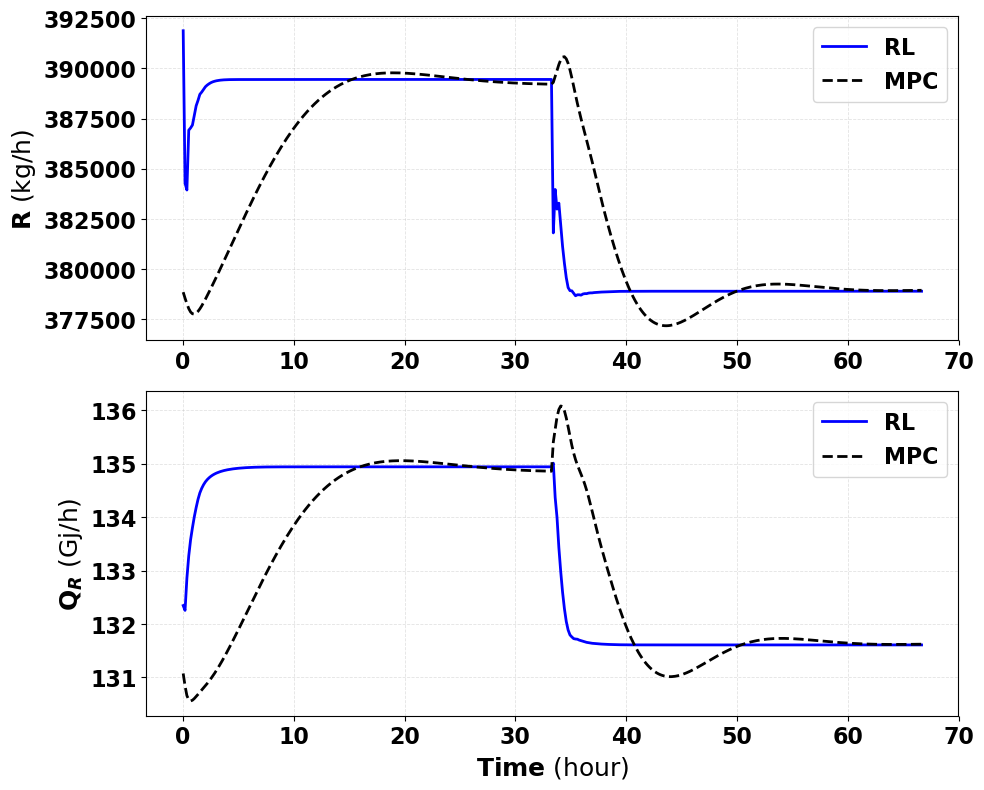

In [134]:
# save_path = os.path.join(dir_path, "mpc_results_RL_compare.pickle")
# with open(save_path, 'rb') as file:
#     mpc_results = pickle.load(file)
y_mpc = mpc_results["y_mpc"]
u_mpc = mpc_results["u_mpc"]
xhatdhat_mpc = mpc_results["xhatdhat"]
avg_rewards_mpc = mpc_results["avg_rewards"]
compare_mpc_rl_disturbance(y_system, y_mpc, y_sp, u_mpc, u_rl, avg_rewards, avg_reward_mpc_, time_in_sub_episodes, delta_t)

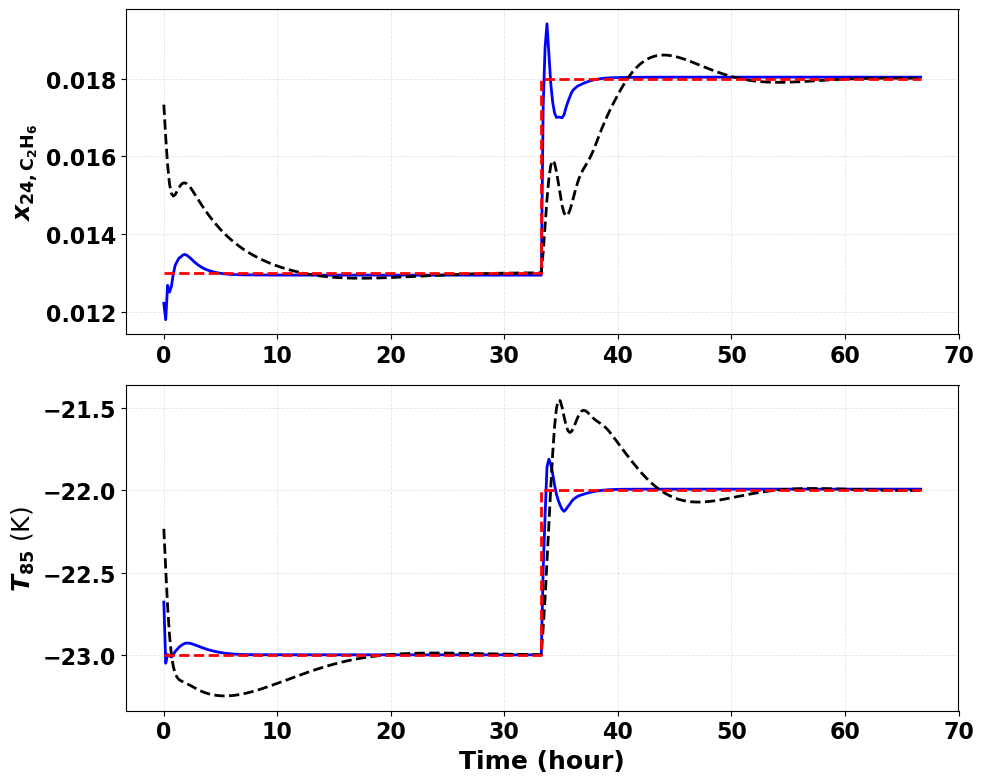

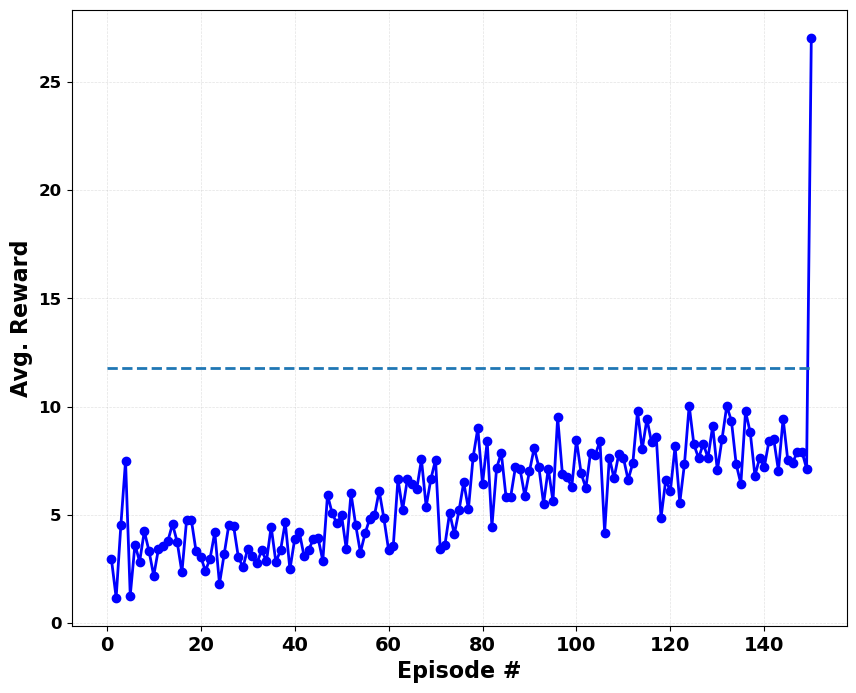

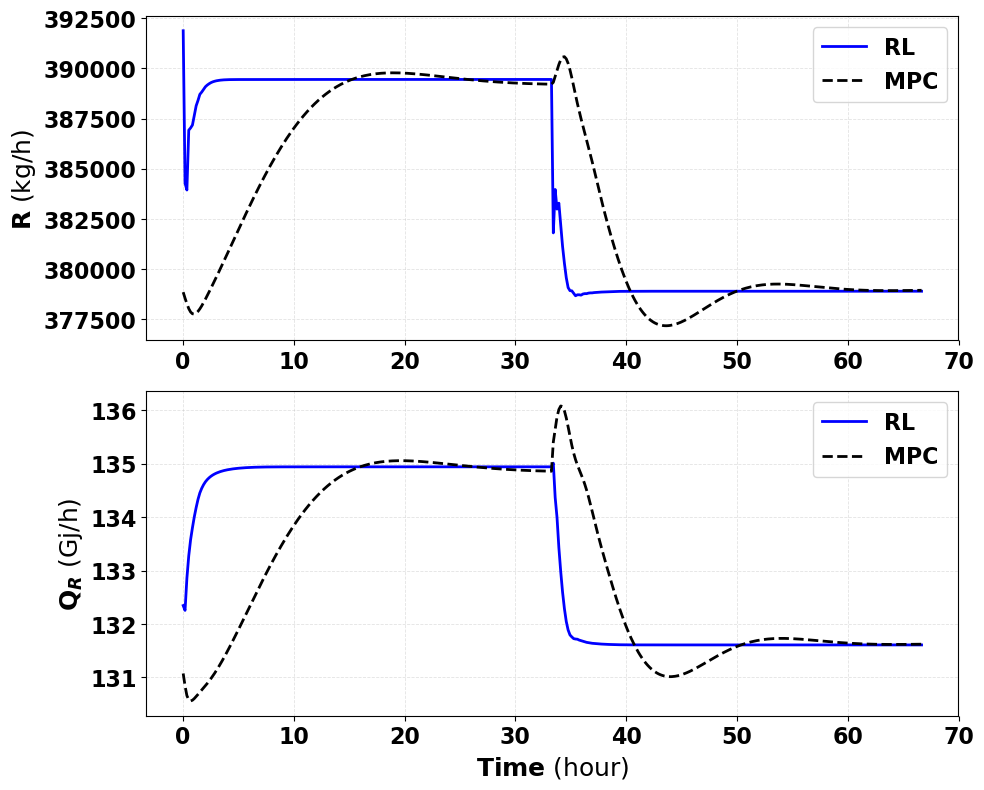

In [135]:
compare_mpc_rl_disturbance(y_system, y_mpc, y_sp, u_mpc, u_rl, avg_rewards, avg_reward_mpc_, time_in_sub_episodes, delta_t)